In [1]:
import pandas as pd
import torch.nn as nn
from tbnn.training_utils import early_stopped_tbnn_training_run
import torch
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import tbnn.models as models
import tbnn.devices as devices
import tbnn.dataloaders as dataloaders
import tbnn.losses as losses
device = devices.get_device()



In [2]:
dataset_params = {'file': '/home/ryley/WDK/ML/dataset/komegasst_fp_phll.csv',
                  'test_set': ['case_1p2'],
                }

df = pd.read_csv(dataset_params['file'])

df = df[df['Case'].isin(['case_1p0', 'case_0p8','case_1p2'])]
df_test = df[df['Case'].isin(dataset_params['test_set'])]
df_tv = df[~df['Case'].isin(dataset_params['test_set'])]
df_tv = df_tv.sample(frac=0.3)

print(f'Dataset: {len(df)}, test: {len(df_test)}, tv: {len(df_tv)}')



Dataset: 44253, test: 14751, tv: 8851


Training points: 4463, validation points 4388
EPOCH    LR        TRAIN     VALID         MSE:T/V              RL:T/V         %NR_t/%NR_v
  1   1.000e-03   0.01021   0.00993   0.01021 / 0.00993   0.00000 / 0.00000   0.02% / 0.00%
 10   9.928e-04   0.00488   0.00457   0.00482 / 0.00456   0.00001 / 0.00000   0.16% / 0.11%
 20   9.849e-04   0.00405   0.00387   0.00400 / 0.00383   0.00000 / 0.00000   0.65% / 0.62%
 30   9.771e-04   0.00381   0.00364   0.00378 / 0.00362   0.00000 / 0.00000   0.47% / 0.48%
 40   9.693e-04   0.00362   0.00347   0.00360 / 0.00344   0.00000 / 0.00000   0.63% / 0.89%
 50   9.615e-04   0.00350   0.00335   0.00349 / 0.00334   0.00000 / 0.00000   0.16% / 0.36%
 60   9.539e-04   0.00338   0.00323   0.00337 / 0.00323   0.00000 / 0.00000   0.09% / 0.18%
 70   9.463e-04   0.00324   0.00311   0.00324 / 0.00309   0.00000 / 0.00000   0.54% / 0.71%
 80   9.387e-04   0.00315   0.00301   0.00314 / 0.00299   0.00000 / 0.00000   0.34% / 0.36%
 90   9.312e-04   0.00303   0.00290

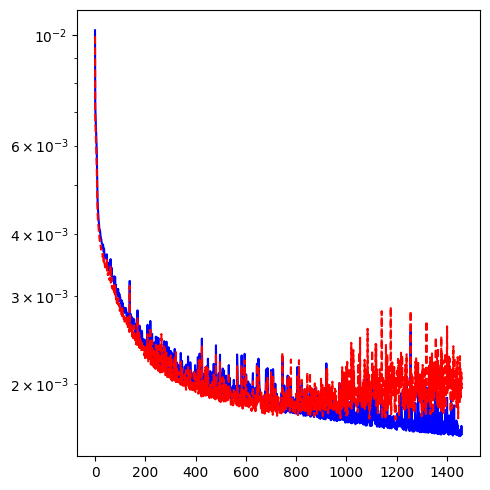

In [3]:
training_params = {'early_stopping_patience': 500,
                    'max_epochs': 1500,
                      'learning_rate': 0.001,
                        'learning_rate_decay': 0.9992,
                          'batch_size': 64,
                            'val_set': ['case_0p8']}

model_params = {'neurons': 20, 'n_hidden': 5, 'activation_function': nn.SiLU(),                 
                #'input_features': ['komegasst_q6','komegasst_q5','komegasst_I1_1','komegasst_I1_3','komegasst_I2_3','komegasst_I1_5']
                'input_features':['komegasst_I1_1',
'komegasst_I1_3',
'komegasst_I1_4',
'komegasst_I1_5',
#'komegasst_I1_16',
#'komegasst_I1_7',
#'komegasst_I1_9',
#'komegasst_I1_10',
#'komegasst_I1_12',
#'komegasst_I1_13',
#'komegasst_I1_16',
'komegasst_q5',
#'komegasst_q6',
]
}

model = models.TBNNPerpPlus(N = 10,
                input_dim = len(model_params['input_features']),
                n_hidden = model_params['n_hidden'],
                neurons = model_params['neurons'],
                activation_function = model_params['activation_function'],
                input_feature_names=model_params['input_features']
            ).to(device)

model, loss_vals, val_loss_vals  = early_stopped_tbnn_training_run(model = model,
                                                                   training_params = training_params,
                                                                   df_tv = df_tv,
                                                                   data_loader=dataloaders.bPerpDataset
                                                                   )


fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(loss_vals,'-',color='b')
ax.plot(val_loss_vals,'--',color='r')
ax.semilogy()
fig.tight_layout()
#fig.savefig(f'models/model_cluster_{cluster}.png',dpi=300)

In [12]:
import tbnn.training_utils as training_utils
import numpy as np
from torch.utils.data import Dataset, DataLoader

df_train = df[~df['Case'].isin(dataset_params['test_set']+training_params['val_set'])]
#df_test = df[df['Case'].isin(test_set)].copy()


df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
df_test[f'pred_b_13_all'] = np.zeros(len(df_test))
df_test[f'pred_b_22_all'] = np.zeros(len(df_test))
df_test[f'pred_b_23_all'] = np.zeros(len(df_test))
df_test[f'pred_b_33_all'] = np.zeros(len(df_test))


#model_params = pickle.load(open(f"models/params_cluster_all.pickle", "rb"))
#df_train_i = df_train[df_train['Cluster'] == cluster]
#df_test_i = df_test[df_test['Cluster'] == cluster].copy()

tDs = dataloaders.bPerpDataset(df_train, input_features=model_params['input_features'])
testDs = dataloaders.bPerpDataset(df_test, input_features=model_params['input_features'],scaler_X = tDs.scaler_X)

model.eval()
for X, T, y in DataLoader(testDs, shuffle=False, batch_size=testDs.__len__()):
    y_pred_test, gn = model(X,T)
    #print(f"loss: {losses.bLoss(y_pred_test,y)}")
    #print(f"loss: {losses.mseLoss(y_pred_test,y)}")
    #print(f"loss: {losses.realizabilityPenalty(y)}")
    #print(f"loss: {losses.realizabilityPenalty_components(y)}")
    #print(f"loss: {losses.realizabilityPenalty_eigs(y)}")

    bperp_pred_test = torch.sum(gn[:,1:11].view(-1,9,1,1)*torch.ones_like(T[:,1:11,:])*T[:,1:11,:],axis=1)
    #val_loss_values.append(loss_fn(y_pred_val,y).item())   
    #mse_v = mseLoss(y_pred_val,y).item()  
    #rl_v = realizLoss(y_pred_val,y).item()
#for prediction_name in ['pred_b_11','pred_b_12','pred_b_13','pred_b_22','pred_b_23','pred_b_33']:
#print(y_pred_test.shape)
df_test[f'pred_b_11_all'] = y_pred_test[:,0,0].detach().numpy()
df_test[f'pred_b_12_all'] = y_pred_test.detach().numpy()[:,0,1]
df_test[f'pred_b_13_all'] = y_pred_test.detach().numpy()[:,0,2]
df_test[f'pred_b_22_all'] = y_pred_test.detach().numpy()[:,1,1]
df_test[f'pred_b_23_all'] = y_pred_test.detach().numpy()[:,1,2]
df_test[f'pred_b_33_all'] = y_pred_test.detach().numpy()[:,2,2]

df_test[f'pred_g2'] = gn[:,0].detach().numpy()
df_test[f'pred_g3'] = gn[:,1].detach().numpy()
df_test[f'pred_g4'] = gn[:,2].detach().numpy()
df_test[f'pred_g5'] = gn[:,3].detach().numpy()
df_test[f'pred_g6'] = gn[:,4].detach().numpy()
df_test[f'pred_g7'] = gn[:,5].detach().numpy()
df_test[f'pred_g8'] = gn[:,6].detach().numpy()
df_test[f'pred_g9'] = gn[:,7].detach().numpy()
df_test[f'pred_g10'] = gn[:,8].detach().numpy()





/tmp/ipykernel_52128/3846458521.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'pred_b_11_all'] = np.zeros(len(df_test))
/tmp/ipykernel_52128/3846458521.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'pred_b_12_all'] = np.zeros(len(df_test))
/tmp/ipykernel_52128/3846458521.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

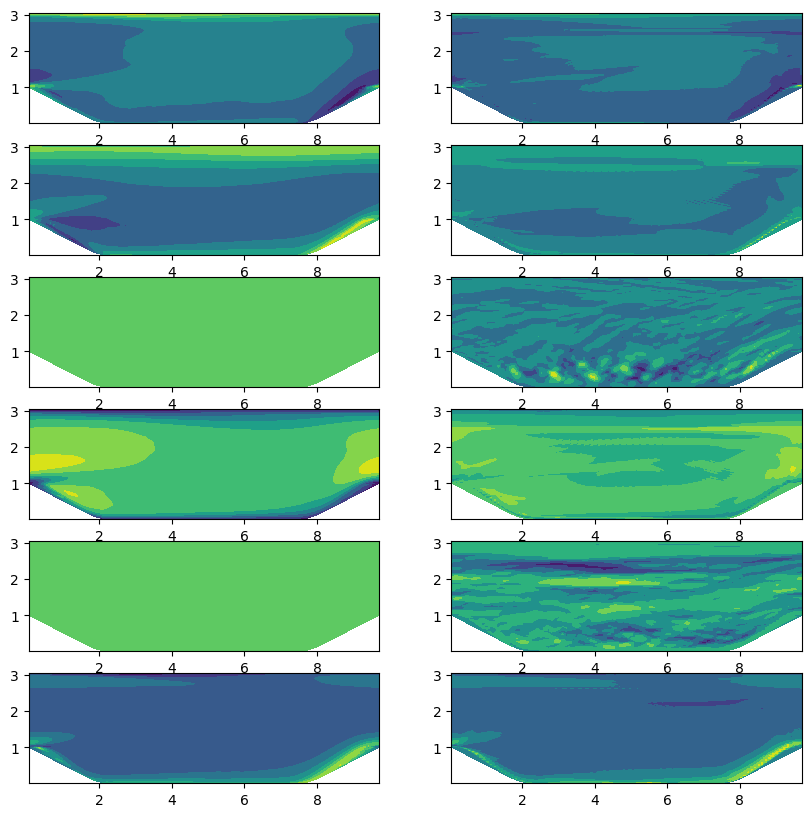

In [5]:
fig, axs = plt.subplots(nrows=6,ncols=2,figsize=(10,10))
axs[0,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_11'])
axs[0,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_11_all'])

axs[1,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_12'])
axs[1,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_12_all'])

axs[2,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_13'])
axs[2,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_13_all'])

axs[3,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_22'])
axs[3,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_22_all'])

axs[4,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_23'])
axs[4,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_23_all'])

axs[5,0].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['DNS_b_33'])
axs[5,1].tricontourf(df_test['komegasst_C_1'],df_test['komegasst_C_2'],df_test['pred_b_33_all'])

for ax in axs.reshape(-1): 
    ax.set_aspect(1)


In [11]:
print(bperp_pred_test.shape)
print(T[:,1:11,:].shape)

torch.Size([14751, 3, 3])
torch.Size([14751, 9, 3, 3])


In [22]:
k_DNS = np.load('/home/ryley/WDK/ML/dataset/numpy/DNS/DNS_case_1p2_k.npy')

aperp_pred = 2*k_DNS[:,None,None]*bperp_pred_test.detach().numpy()
print(aperp_pred.shape)

(14751, 3, 3)


In [23]:
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/ryley/WDK/ML/code/data_scripting/dataFoam')
from utilities.foamIO import writeFoam_PHLL

writeFoam_PHLL.writeFoam_ap_PHLL('/home/ryley/WDK/ML/scratch/injection/case_1p2_testing_models/0/aperp',aperp_pred)

Writing aperp to file /home/ryley/WDK/ML/scratch/injection/case_1p2_testing_models/0/aperp
